# 1. Импорт библиотек и загрузка данных

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statistics import mode
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import PolynomialFeatures
from sklearn.feature_selection import SelectFromModel
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import RandomForestRegressor
from catboost import CatBoostClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
import warnings
warnings.filterwarnings('ignore')

В данном ноутбуке я буду работать с данными о погоде в различных регионах Австралии и обучу модель, которая сможет ответить на следующий вопрос: будет завтра идти дождь или нет.

Для данного предсказания я построю модель логистической регрессии и буду пошагово улучшать качество её работы по мере внедрения различных этапов работы с данными.

В конце я построю более продвинутую модель - CatBoostClassifier и попробую оптимизировать её гиперпараметры.

In [2]:
df = pd.read_csv('weatherAUS.csv')
df.head()

,Date,Location,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustDir,WindGustSpeed,WindDir9am,...,Humidity9am,Humidity3pm,Pressure9am,Pressure3pm,Cloud9am,Cloud3pm,Temp9am,Temp3pm,RainToday,RainTomorrow
0,2008-12-01,Albury,13.4,22.9,0.6,NaN,NaN,W,44.0,W,...,71.0,22.0,1007.7,1007.1,8.0,NaN,16.9,21.8,No,No
1,2008-12-02,Albury,7.4,25.1,0.0,NaN,NaN,WNW,44.0,NNW,...,44.0,25.0,1010.6,1007.8,NaN,NaN,17.2,24.3,No,No
2,2008-12-03,Albury,12.9,25.7,0.0,NaN,NaN,WSW,46.0,W,...,38.0,30.0,1007.6,1008.7,NaN,2.0,21.0,23.2,No,No
3,2008-12-04,Albury,9.2,28.0,0.0,NaN,NaN,NE,24.0,SE,...,45.0,16.0,1017.6,1012.8,NaN,NaN,18.1,26.5,No,No
4,2008-12-05,Albury,17.5,32.3,1.0,NaN,NaN,W,41.0,ENE,...,82.0,33.0,1010.8,1006.0,7.0,8.0,17.8,29.7,No,No


Можно заметить, что датасет состоит из категориальных и числовых переменных. 

Также видно, что есть пропуски в данных. Будем работать с ними в дальнейшем.

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 145460 entries, 0 to 145459
Data columns (total 23 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   Date           145460 non-null  object 
 1   Location       145460 non-null  object 
 2   MinTemp        143975 non-null  float64
 3   MaxTemp        144199 non-null  float64
 4   Rainfall       142199 non-null  float64
 5   Evaporation    82670 non-null   float64
 6   Sunshine       75625 non-null   float64
 7   WindGustDir    135134 non-null  object 
 8   WindGustSpeed  135197 non-null  float64
 9   WindDir9am     134894 non-null  object 
 10  WindDir3pm     141232 non-null  object 
 11  WindSpeed9am   143693 non-null  float64
 12  WindSpeed3pm   142398 non-null  float64
 13  Humidity9am    142806 non-null  float64
 14  Humidity3pm    140953 non-null  float64
 15  Pressure9am    130395 non-null  float64
 16  Pressure3pm    130432 non-null  float64
 17  Cloud9am       89572 non-null

# 2. Анализ переменных

## 2.1 Анализ целевой переменной

Проверяю наличие нулевых значений.

In [4]:
df['RainTomorrow'].isnull().sum()

3267

Удалю данные с пропусками в целевой переменной, так как они непригодны для обучения.

In [5]:
df.dropna(subset='RainTomorrow', inplace=True)
df.reset_index(drop=True, inplace=True)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 142193 entries, 0 to 142192
Data columns (total 23 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   Date           142193 non-null  object 
 1   Location       142193 non-null  object 
 2   MinTemp        141556 non-null  float64
 3   MaxTemp        141871 non-null  float64
 4   Rainfall       140787 non-null  float64
 5   Evaporation    81350 non-null   float64
 6   Sunshine       74377 non-null   float64
 7   WindGustDir    132863 non-null  object 
 8   WindGustSpeed  132923 non-null  float64
 9   WindDir9am     132180 non-null  object 
 10  WindDir3pm     138415 non-null  object 
 11  WindSpeed9am   140845 non-null  float64
 12  WindSpeed3pm   139563 non-null  float64
 13  Humidity9am    140419 non-null  float64
 14  Humidity3pm    138583 non-null  float64
 15  Pressure9am    128179 non-null  float64
 16  Pressure3pm    128212 non-null  float64
 17  Cloud9am       88536 non-null

Проверю, что в целевой переменной нет лишних значений и проверю распределение классов.

In [6]:
df['RainTomorrow'].value_counts()

RainTomorrow
No     110316
Yes     31877
Name: count, dtype: int64

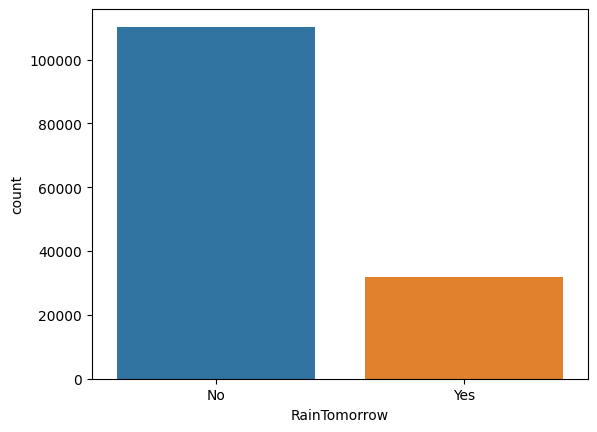

In [7]:
sns.countplot(x='RainTomorrow', data=df);

Целевая переменная не содержит лишних значений.

Также можно сказать, что есть небольшой дисбаланс классов в целевой переменной.

## 2.2 Анализ категориальных переменных

Найду категориальные переменные - в данном случае это переменные с типом данных object

In [8]:
categorical = [var for var in df.columns if df[var].dtype=='object']

print(f'{len(categorical)} Категориальных переменных: {categorical}.')

7 Категориальных переменных: ['Date', 'Location', 'WindGustDir', 'WindDir9am', 'WindDir3pm', 'RainToday', 'RainTomorrow'].


Всего в датасете 7 категориальных переменных, при этом одна из переменных содержит даты и ещё одна является целевой переменной. Удалим целевую переменную из данного списка и проверим количество уникальных значений в каждой из этих переменных.

In [9]:
categorical.remove('RainTomorrow')

In [10]:
df[categorical].head()

,Date,Location,WindGustDir,WindDir9am,WindDir3pm,RainToday
0,2008-12-01,Albury,W,W,WNW,No
1,2008-12-02,Albury,WNW,NNW,WSW,No
2,2008-12-03,Albury,WSW,W,WSW,No
3,2008-12-04,Albury,NE,SE,E,No
4,2008-12-05,Albury,W,ENE,NW,No


In [11]:
for var in categorical:
    
    print(f'{var} содержит {len(df[var].unique())} уникальных значений.')

Date содержит 3436 уникальных значений.
Location содержит 49 уникальных значений.
WindGustDir содержит 17 уникальных значений.
WindDir9am содержит 17 уникальных значений.
WindDir3pm содержит 17 уникальных значений.
RainToday содержит 3 уникальных значений.


Переменная с датами содержит огромное количество уникальных значений. Нужно её распарсить, иначе при кодировании категориальных переменных с помощью OneHotEncoding будет создано более 3000 новых переменных, что увеличит размерность датасета более, чем в 100 раз и негативно скажется на качестве модели.

### 2.2.1 Date

Распарсим дату и получим 3 новые переменные, которые будут содержать данные о годе, месяце и дне.

In [12]:
df['Date'] = pd.to_datetime(df['Date'])

In [13]:
df['Year'] = df['Date'].dt.year
df['Year'].head()

0    2008
1    2008
2    2008
3    2008
4    2008
Name: Year, dtype: int32

In [14]:
df['Month'] = df['Date'].dt.month
df['Month'].head()

0    12
1    12
2    12
3    12
4    12
Name: Month, dtype: int32

In [15]:
df['Day'] = df['Date'].dt.day
df['Day'].head()

0    1
1    2
2    3
3    4
4    5
Name: Day, dtype: int32

Удаляю столбец с датой после извлечения всей возможной информации.

Также удаляю столбец с датой из списка категориальных переменных.

In [16]:
df.drop(columns='Date', inplace=True)
categorical.remove('Date')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 142193 entries, 0 to 142192
Data columns (total 25 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   Location       142193 non-null  object 
 1   MinTemp        141556 non-null  float64
 2   MaxTemp        141871 non-null  float64
 3   Rainfall       140787 non-null  float64
 4   Evaporation    81350 non-null   float64
 5   Sunshine       74377 non-null   float64
 6   WindGustDir    132863 non-null  object 
 7   WindGustSpeed  132923 non-null  float64
 8   WindDir9am     132180 non-null  object 
 9   WindDir3pm     138415 non-null  object 
 10  WindSpeed9am   140845 non-null  float64
 11  WindSpeed3pm   139563 non-null  float64
 12  Humidity9am    140419 non-null  float64
 13  Humidity3pm    138583 non-null  float64
 14  Pressure9am    128179 non-null  float64
 15  Pressure3pm    128212 non-null  float64
 16  Cloud9am       88536 non-null   float64
 17  Cloud3pm       85099 non-null

### 2.2.2 Location

Проверяю наличие пропусков.

In [17]:
df['Location'].isnull().sum()

0

Проверяю количество уникальных значений.

In [18]:
print(f'Переменная Location содержит {len(df.Location.unique())} уникальных значений.')

Переменная Location содержит 49 уникальных значений.


Нужно проверить уникальные значения, чтобы убедиться, что наименования всех значений адекватны и за ними не скрываются пропуски.

In [19]:
df['Location'].unique()

array(['Albury', 'BadgerysCreek', 'Cobar', 'CoffsHarbour', 'Moree',
       'Newcastle', 'NorahHead', 'NorfolkIsland', 'Penrith', 'Richmond',
       'Sydney', 'SydneyAirport', 'WaggaWagga', 'Williamtown',
       'Wollongong', 'Canberra', 'Tuggeranong', 'MountGinini', 'Ballarat',
       'Bendigo', 'Sale', 'MelbourneAirport', 'Melbourne', 'Mildura',
       'Nhil', 'Portland', 'Watsonia', 'Dartmoor', 'Brisbane', 'Cairns',
       'GoldCoast', 'Townsville', 'Adelaide', 'MountGambier', 'Nuriootpa',
       'Woomera', 'Albany', 'Witchcliffe', 'PearceRAAF', 'PerthAirport',
       'Perth', 'SalmonGums', 'Walpole', 'Hobart', 'Launceston',
       'AliceSprings', 'Darwin', 'Katherine', 'Uluru'], dtype=object)

Я проверил все наименования и убедился, что они соответствуют названиям городов, отдельных частей городов или территорий в Австралии.

### 2.2.3 WindGustDir

Проверяю наличие пропусков.

In [20]:
df['WindGustDir'].isnull().sum()

9330

Проверяю распределение данных вместе с пропусками.

In [21]:
df['WindGustDir'].value_counts(dropna=False)

WindGustDir
W      9780
NaN    9330
SE     9309
E      9071
N      9033
SSE    8993
S      8949
WSW    8901
SW     8797
SSW    8610
WNW    8066
NW     8003
ENE    7992
ESE    7305
NE     7060
NNW    6561
NNE    6433
Name: count, dtype: int64

Видно, что данные распределены достаточно равномерно, при этом есть много пропусков. Если просто заменить пропуски модой, вероятно, это внесёт сильный дисбаланс, поэтому я протестирую как и способ заполнения модой, так и способ заполнения с помощью модели классификации, обученной на других признаках. Реализую это в конце раздела работы с категориальными переменными.

Проверяю количество уникальных значений.

In [22]:
print(f'Переменная WindGustDir содержит {len(df.WindGustDir.unique())} уникальных значений.')

Переменная WindGustDir содержит 17 уникальных значений.


Проверяю наименования значений.

In [23]:
df['WindGustDir'].unique()

array(['W', 'WNW', 'WSW', 'NE', 'NNW', 'N', 'NNE', 'SW', 'ENE', 'SSE',
       'S', 'NW', 'SE', 'ESE', nan, 'E', 'SSW'], dtype=object)

Так как в этой переменной содержатся данные о направлении ветра и, например, SE означает South-East, можно считать все наименования адекватными.

### 2.2.4 WindDir9am

Проверяю наличие пропусков.

In [24]:
df['WindDir9am'].isnull().sum()

10013

Проверяю распределение данных вместе с пропусками.

In [25]:
df['WindDir9am'].value_counts(dropna=False)

WindDir9am
N      11393
NaN    10013
SE      9162
E       9024
SSE     8966
NW      8552
S       8493
W       8260
SW      8237
NNE     7948
NNW     7840
ENE     7735
ESE     7558
NE      7527
SSW     7448
WNW     7194
WSW     6843
Name: count, dtype: int64

Проверяю количество уникальных значений.

In [26]:
print(f'Переменная WindDir9am содержит {len(df.WindDir9am.unique())} уникальных значений.')

Переменная WindDir9am содержит 17 уникальных значений.


Проверяю наименования значений.

In [27]:
df['WindDir9am'].unique()

array(['W', 'NNW', 'SE', 'ENE', 'SW', 'SSE', 'S', 'NE', nan, 'SSW', 'N',
       'WSW', 'ESE', 'E', 'NW', 'WNW', 'NNE'], dtype=object)

В этой переменной так же содержатся данные о направления ветра, так что наименования адекватные.

### 2.2.5 WindDir3pm 

Проверяю наличие пропусков

In [28]:
df['WindDir3pm'].isnull().sum()

3778

Проверяю распределение данных вместе с пропусками.

In [29]:
df['WindDir3pm'].value_counts(dropna=False)

WindDir3pm
SE     10663
W       9911
S       9598
WSW     9329
SW      9182
SSE     9142
N       8667
WNW     8656
NW      8468
ESE     8382
E       8342
NE      8164
SSW     8010
NNW     7733
ENE     7724
NNE     6444
NaN     3778
Name: count, dtype: int64

В данной переменной так же наблюдается равномерное распределение, при этом пропусков здесь меньше.

Проверяю количество уникальных значений.

In [30]:
print(f'Переменная WindDir3pm содержит {len(df.WindDir3pm.unique())} уникальных значений.')

Переменная WindDir3pm содержит 17 уникальных значений.


Проверяю наименования значений.

In [31]:
df['WindDir3pm'].unique()

array(['WNW', 'WSW', 'E', 'NW', 'W', 'SSE', 'ESE', 'ENE', 'NNW', 'SSW',
       'SW', 'SE', 'N', 'S', 'NNE', nan, 'NE'], dtype=object)

В этой переменной так же содержатся данные о направления ветра, так что наименования адекватные.

### 2.2.6 RainToday

Проверяю наличие пропусков.

In [32]:
df['RainToday'].isnull().sum()

1406

Проверяю распределение данных вместе с пропусками.

In [33]:
df['RainToday'].value_counts(dropna=False)

RainToday
No     109332
Yes     31455
NaN      1406
Name: count, dtype: int64

В данном случае пропусков относительно немного и замена модой не должна внести сильный дисбаланс в данные.

Также из результата выполнения предыдущей ячейки видно, что у нас всего 2 уникальных значения в переменной, что является адекватным.

## 2.3 Анализ числовых переменных

Найду числовые переменные - в данном случае это переменные с типом данных float.

In [34]:
numerical = [var for var in df.columns if df[var].dtype=='float']

print(f'{len(numerical)} Числовых переменных: {numerical}.')

16 Числовых переменных: ['MinTemp', 'MaxTemp', 'Rainfall', 'Evaporation', 'Sunshine', 'WindGustSpeed', 'WindSpeed9am', 'WindSpeed3pm', 'Humidity9am', 'Humidity3pm', 'Pressure9am', 'Pressure3pm', 'Cloud9am', 'Cloud3pm', 'Temp9am', 'Temp3pm'].


Вывожу данные о статистике.

На первый взгляд есть выбросы в признаках Rainfall, Evaporation, WindSpeed9am и WindSpeed3pm, так как максимальные значения в этих столбцах многократно отличаются от медианных. Далее исследуем все числовые переменные на наличие выбросов.

In [35]:
df[numerical].describe()

,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustSpeed,WindSpeed9am,WindSpeed3pm,Humidity9am,Humidity3pm,Pressure9am,Pressure3pm,Cloud9am,Cloud3pm,Temp9am,Temp3pm
count,141556.000000,141871.000000,140787.000000,81350.000000,74377.000000,132923.000000,140845.000000,139563.000000,140419.000000,138583.000000,128179.000000,128212.000000,88536.000000,85099.000000,141289.000000,139467.000000
mean,12.186400,23.226784,2.349974,5.469824,7.624853,39.984292,14.001988,18.637576,68.843810,51.482606,1017.653758,1015.258204,4.437189,4.503167,16.987509,21.687235
std,6.403283,7.117618,8.465173,4.188537,3.781525,13.588801,8.893337,8.803345,19.051293,20.797772,7.105476,7.036677,2.887016,2.720633,6.492838,6.937594
min,-8.500000,-4.800000,0.000000,0.000000,0.000000,6.000000,0.000000,0.000000,0.000000,0.000000,980.500000,977.100000,0.000000,0.000000,-7.200000,-5.400000
25%,7.600000,17.900000,0.000000,2.600000,4.900000,31.000000,7.000000,13.000000,57.000000,37.000000,1012.900000,1010.400000,1.000000,2.000000,12.300000,16.600000
50%,12.000000,22.600000,0.000000,4.800000,8.500000,39.000000,13.000000,19.000000,70.000000,52.000000,1017.600000,1015.200000,5.000000,5.000000,16.700000,21.100000
75%,16.800000,28.200000,0.800000,7.400000,10.600000,48.000000,19.000000,24.000000,83.000000,66.000000,1022.400000,1020.000000,7.000000,7.000000,21.600000,26.400000
max,33.900000,48.100000,371.000000,145.000000,14.500000,135.000000,130.000000,87.000000,100.000000,100.000000,1041.000000,1039.600000,9.000000,9.000000,40.200000,46.700000


Text(0, 0.5, 'Evaporation')

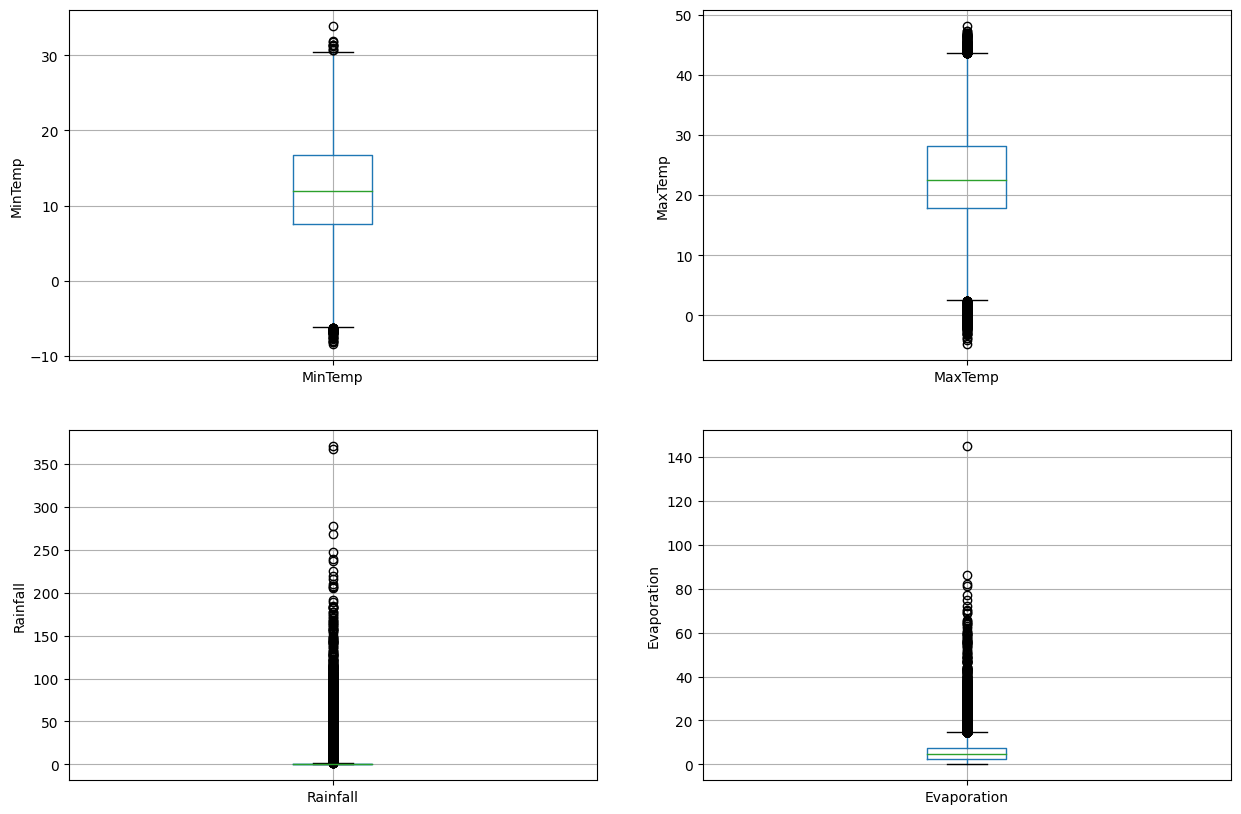

In [36]:
plt.figure(figsize=(15,10))

plt.subplot(2, 2, 1)
fig = df.boxplot(column='MinTemp')
fig.set_title('')
fig.set_ylabel('MinTemp')

plt.subplot(2, 2, 2)
fig = df.boxplot(column='MaxTemp')
fig.set_title('')
fig.set_ylabel('MaxTemp')

plt.subplot(2, 2, 3)
fig = df.boxplot(column='Rainfall')
fig.set_title('')
fig.set_ylabel('Rainfall')

plt.subplot(2, 2, 4)
fig = df.boxplot(column='Evaporation')
fig.set_title('')
fig.set_ylabel('Evaporation')

Text(0, 0.5, 'WindSpeed3pm')

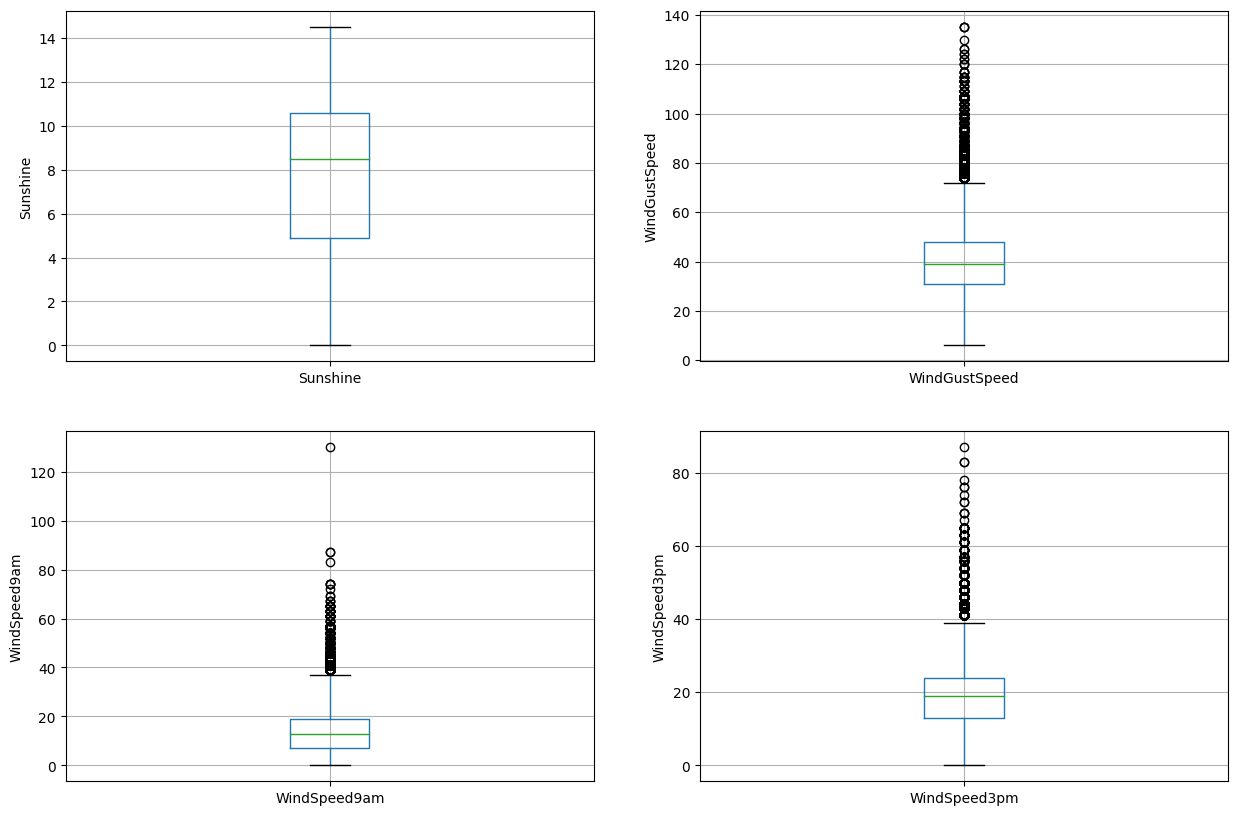

In [37]:
plt.figure(figsize=(15,10))

plt.subplot(2, 2, 1)
fig = df.boxplot(column='Sunshine')
fig.set_title('')
fig.set_ylabel('Sunshine')

plt.subplot(2, 2, 2)
fig = df.boxplot(column='WindGustSpeed')
fig.set_title('')
fig.set_ylabel('WindGustSpeed')

plt.subplot(2, 2, 3)
fig = df.boxplot(column='WindSpeed9am')
fig.set_title('')
fig.set_ylabel('WindSpeed9am')

plt.subplot(2, 2, 4)
fig = df.boxplot(column='WindSpeed3pm')
fig.set_title('')
fig.set_ylabel('WindSpeed3pm')

Text(0, 0.5, 'Pressure3pm')

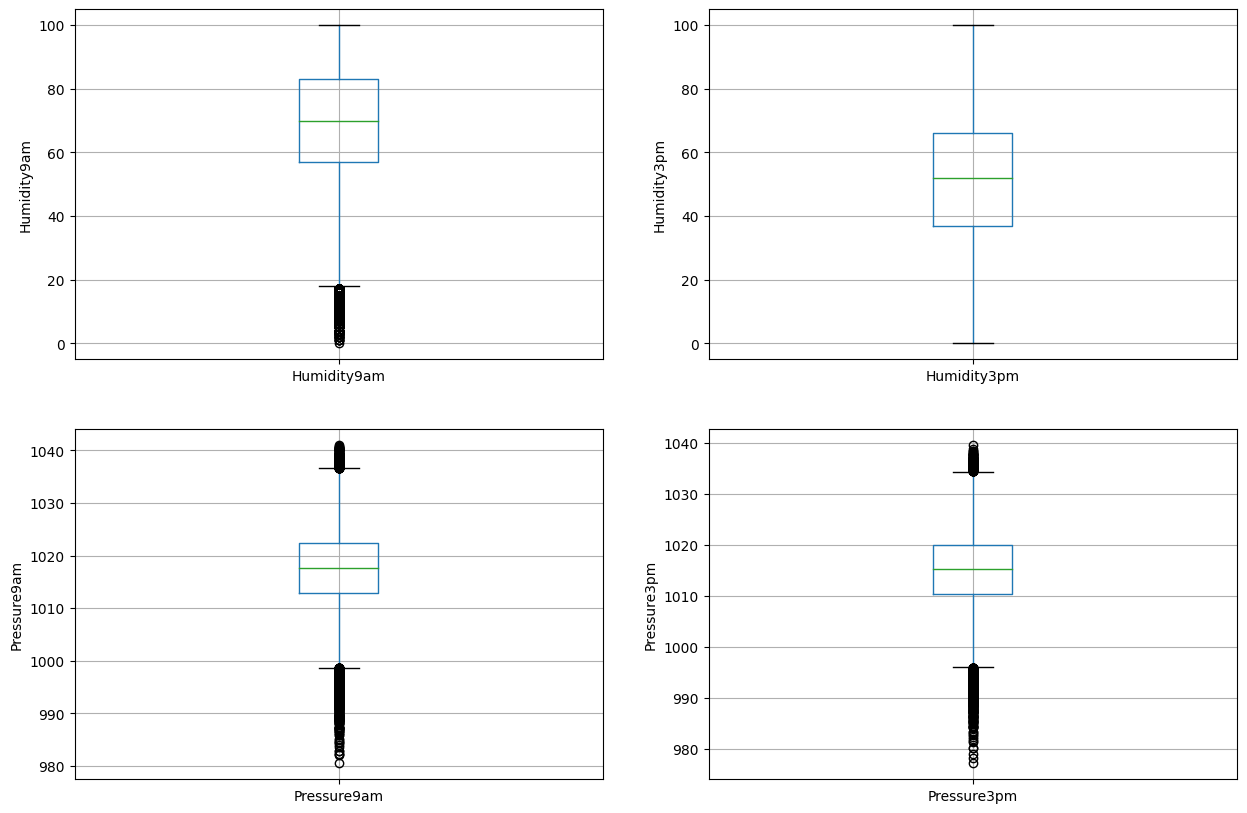

In [38]:
plt.figure(figsize=(15,10))

plt.subplot(2, 2, 1)
fig = df.boxplot(column='Humidity9am')
fig.set_title('')
fig.set_ylabel('Humidity9am')

plt.subplot(2, 2, 2)
fig = df.boxplot(column='Humidity3pm')
fig.set_title('')
fig.set_ylabel('Humidity3pm')

plt.subplot(2, 2, 3)
fig = df.boxplot(column='Pressure9am')
fig.set_title('')
fig.set_ylabel('Pressure9am')

plt.subplot(2, 2, 4)
fig = df.boxplot(column='Pressure3pm')
fig.set_title('')
fig.set_ylabel('Pressure3pm')

Text(0, 0.5, 'Temp3pm')

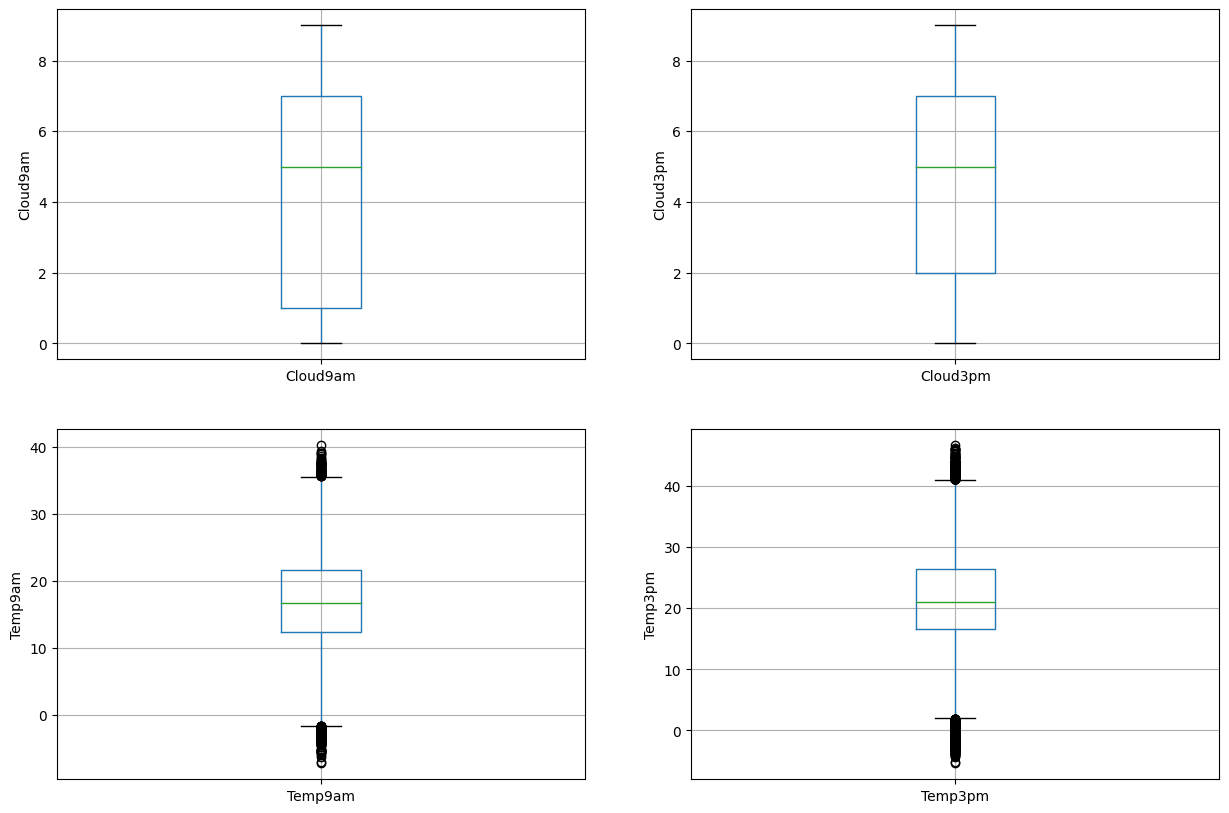

In [39]:
plt.figure(figsize=(15,10))

plt.subplot(2, 2, 1)
fig = df.boxplot(column='Cloud9am')
fig.set_title('')
fig.set_ylabel('Cloud9am')

plt.subplot(2, 2, 2)
fig = df.boxplot(column='Cloud3pm')
fig.set_title('')
fig.set_ylabel('Cloud3pm')

plt.subplot(2, 2, 3)
fig = df.boxplot(column='Temp9am')
fig.set_title('')
fig.set_ylabel('Temp9am')

plt.subplot(2, 2, 4)
fig = df.boxplot(column='Temp3pm')
fig.set_title('')
fig.set_ylabel('Temp3pm')

Согласно статистическому исследованию, выбросы присутствуют во всех переменных, кроме следующих: Sunshine, Humidity3pm, Cloud9am и Cloud3pm.

Но надо учитывать особенности данного датасета. Например, переменные Rainfall(количество осадков) и Evaporation(испарение) скорее всего напрямую зависят от количества дождливых дней в году, а так как таких дней в несколько раз меньше, чем дней без дождя, логично, что медианные значения этих переменных стремятся к нулю, при этом большие значения в данном случае, по моему мнению, не являются выбросами и адекватно описывают закономерности в данных.

Если удалять все объекты, которые согласно boxplot содержат выбросы, то придётся удалить большую часть данных, что однозначно негативно скажется на качестве модели, поэтому я решил не удалять выбросы.

Теперь посмотрим на матрицу корреляции числовых признаков.

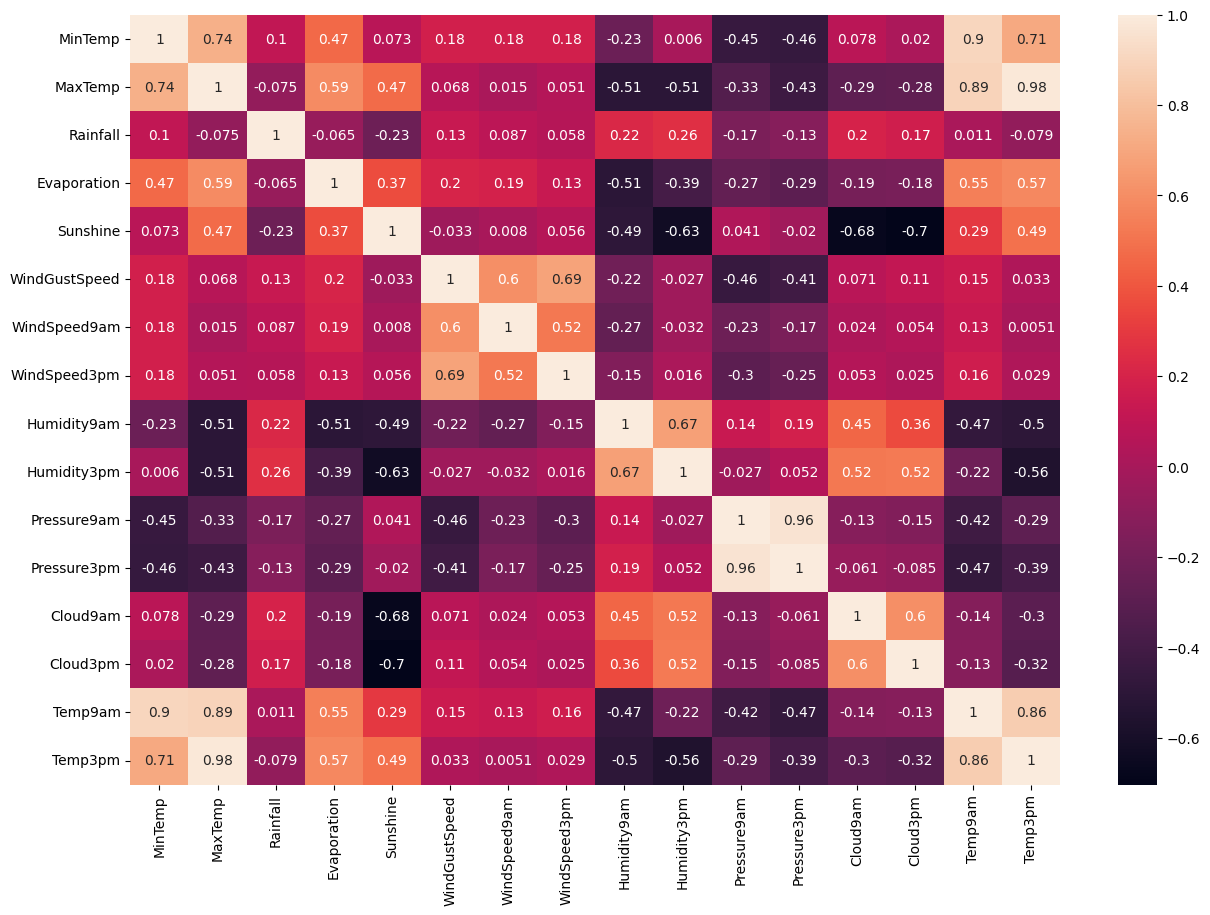

In [40]:
plt.figure(figsize=(15,10))
sns.heatmap(df[numerical].corr(), annot=True);

Видно, что признаки MinTemp, MaxTemp, Temp9am, Temp3pm сильно коррелируют между собой, что может привести к мультиколлинеарности. В дальнейшем попробую удалить один из этих признаков и проверю, приведёт ли это к улучшению качества модели.

# 3. Feature engeneering: Логистическая регрессия

Прежде, чем начать работать с переменными, разделю датасет на признаки для обучения и целевой признак.

In [41]:
X = df.drop(columns='RainTomorrow')
y = df['RainTomorrow']

## 3.1 Работа с пропусками в числовых переменных

Начну заполнение пропусков с числовых переменных.

Объясню свой выбор: для заполнения пропусков в числовых переменных я буду тестировать методы заполнения средним и медианным значениями, а также заполнение с помощью модели регрессии. Для заполнения пропусков в категориальных переменных я буду тестировать методы заполнения модой и заполнение с помощью модели классификации.

Так как признаков для обучения моделей изначально будет мало, есть вероятность, что метод заполнения с помощью модели будет давать плохие результаты и придётся заполнять пропуски статистическими значениями. При заполнении пропусков в числовых переменных медианой, как правило, закономерность в данных будет меньше искажена, чем при заполнении пропусков в категориальных переменных модой. Поэтому я решил сначала заполнить пропуски в числовых переменных и на них обучить модель для заполнения пропусков в категориальных переменных.

В качестве метрики буду использовать точность, так как предполагаю, что нам одинаково важно предсказвать как наличие дождя, так и его отсутствие. В конце ноутбука представлю вариант модели, которая лучше предсказывает наличие дождя в ущерб качеству предсказаний отсутствия дождя.

In [42]:
def select_method_num(X, column, method):

	if method == 'median':
		X_dummies = X.copy()
		X_dummies.loc[X_dummies[X_dummies[column].isna()].index, column] = X_dummies[column].median()

	elif method == 'regmodel':
		X_dummies = pd.get_dummies(X.dropna(axis=1).join(X[column]), columns=['Location'])
		cols = list(X_dummies.columns)
		cols.remove(column)
		X_tmp = X_dummies.dropna()
		model = RandomForestRegressor(random_state=1).fit(X_tmp[cols], X_tmp[column])
		X_dummies.loc[X_dummies[X_dummies[column].isna()].index, column] = model.predict(X_dummies[X_dummies[column].isna()][cols])

	elif method == 'mean':
		X_dummies = X.copy()
		X_dummies.loc[X_dummies[X_dummies[column].isna()].index, column] = X_dummies[column].mean()

	# Тестирование метода заполнения пропусков
	# Тестирование происходит при равных условиях: удаляются все пропуски в других переменных
	# и обучается модель с базовыми параметрами для предсказания целевой переменной
	df_method = df.copy()
	df_method[column] = X_dummies[column]
	df_method.dropna(inplace=True)
	X_method = df_method.drop(columns='RainTomorrow')
	X_method = pd.get_dummies(X_method, columns=categorical)
	y_method = pd.Series(data=LabelEncoder().fit_transform(df_method['RainTomorrow']))
	X_train, X_test, y_train, y_test = train_test_split(X_method, y_method, test_size=0.2, random_state=41)
	model_method = RandomForestClassifier(random_state=1)
	model_method.fit(X_train, y_train)

	return accuracy_score(y_test, model_method.predict(X_test))

Создаю функцию для замены столбца в исходных данных на столбец с заполненными пропусками.

In [43]:
def fill_nan_num(X, column, method):

	if method == 'median':
		X_dummies = X.copy()
		X_dummies.loc[X_dummies[X_dummies[column].isna()].index, column] = X_dummies[column].median()

	elif method == 'regmodel':
		X_dummies = pd.get_dummies(X.dropna(axis=1).join(X[column]), columns=['Location'])
		cols = list(X_dummies.columns)
		cols.remove(column)
		X_tmp = X_dummies.dropna()
		model = RandomForestRegressor(random_state=1).fit(X_tmp[cols], X_tmp[column])
		X_dummies.loc[X_dummies[X_dummies[column].isna()].index, column] = model.predict(X_dummies[X_dummies[column].isna()][cols])

	elif method == 'mean':
		X_dummies = X.copy()
		X_dummies.loc[X_dummies[X_dummies[column].isna()].index, column] = X_dummies[column].mean()

	# Замена столбца в исходных данных на столбец с заполненными пропусками
	X[column] = X_dummies[column]

	return X[numerical].isna().sum().sort_values()

При тестировании модели заполнения пропусков в начале у нас мало признаков для обучения и велика вероятность, что эффективность модели будет невысока и мы получим не самые лучшие предсказания. Поэтому я начну заполнение с признаков с наименьшим количеством пропусков, чтобы минимизировать искажение в данных. Таким образом для признаков с наибольшим количеством пропусков у нас будет больше признаков для обучения.

In [44]:
X[numerical].isna().sum().sort_values()

MaxTemp            322
MinTemp            637
Temp9am            904
WindSpeed9am      1348
Rainfall          1406
Humidity9am       1774
WindSpeed3pm      2630
Temp3pm           2726
Humidity3pm       3610
WindGustSpeed     9270
Pressure3pm      13981
Pressure9am      14014
Cloud9am         53657
Cloud3pm         57094
Evaporation      60843
Sunshine         67816
dtype: int64

### 3.1.1 MaxTemp

In [45]:
select_method_num(X, 'MaxTemp', 'mean')

0.8557377049180328

In [46]:
select_method_num(X, 'MaxTemp', 'median')

0.8558263181214001

In [47]:
select_method_num(X, 'MaxTemp', 'regmodel')

0.8564466105449712

Лучший результат показал метод заполнения с помощью модели случайного леса.

Заменю колонку в исходных данных на колонку с заполненными пропусками.

In [48]:
fill_nan_num(X, 'MaxTemp', 'regmodel')

MaxTemp              0
MinTemp            637
Temp9am            904
WindSpeed9am      1348
Rainfall          1406
Humidity9am       1774
WindSpeed3pm      2630
Temp3pm           2726
Humidity3pm       3610
WindGustSpeed     9270
Pressure3pm      13981
Pressure9am      14014
Cloud9am         53657
Cloud3pm         57094
Evaporation      60843
Sunshine         67816
dtype: int64

### 3.1.2 MinTemp

In [49]:
select_method_num(X, 'MinTemp', 'mean')

0.864280652019844

In [50]:
select_method_num(X, 'MinTemp', 'median')

0.8646350106307583

In [51]:
select_method_num(X, 'MinTemp', 'regmodel')

0.8620659107016301

Лучший результат показал метод заполнения с помощью медианы.

Заменю колонку в исходных данных на колонку с заполненными пропусками.

In [52]:
fill_nan_num(X, 'MinTemp', 'median')

MinTemp              0
MaxTemp              0
Temp9am            904
WindSpeed9am      1348
Rainfall          1406
Humidity9am       1774
WindSpeed3pm      2630
Temp3pm           2726
Humidity3pm       3610
WindGustSpeed     9270
Pressure3pm      13981
Pressure9am      14014
Cloud9am         53657
Cloud3pm         57094
Evaporation      60843
Sunshine         67816
dtype: int64

### 3.1.3 Temp9am

In [53]:
select_method_num(X, 'Temp9am', 'mean')

0.8631690889755406

In [54]:
select_method_num(X, 'Temp9am', 'median')

0.8631690889755406

In [55]:
select_method_num(X, 'Temp9am', 'regmodel')

0.8631690889755406

Все способы показали одинаковый результат. Заполню пропуски медианой, так как это будет быстрее, чем заполнение с помощью модели.

In [56]:
fill_nan_num(X, 'Temp9am', 'median')

MinTemp              0
MaxTemp              0
Temp9am              0
WindSpeed9am      1348
Rainfall          1406
Humidity9am       1774
WindSpeed3pm      2630
Temp3pm           2726
Humidity3pm       3610
WindGustSpeed     9270
Pressure3pm      13981
Pressure9am      14014
Cloud9am         53657
Cloud3pm         57094
Evaporation      60843
Sunshine         67816
dtype: int64

### 3.1.4 WindSpeed9am

In [57]:
select_method_num(X, 'WindSpeed9am', 'mean')

0.8631690889755406

In [58]:
select_method_num(X, 'WindSpeed9am', 'median')

0.8631690889755406

In [59]:
select_method_num(X, 'WindSpeed9am', 'regmodel')

0.8631690889755406

Все способы так же показали одинаковый результат. Как и в предыдущем случае, заполню пропуски медианой.

In [60]:
fill_nan_num(X, 'WindSpeed9am', 'median')

MinTemp              0
MaxTemp              0
WindSpeed9am         0
Temp9am              0
Rainfall          1406
Humidity9am       1774
WindSpeed3pm      2630
Temp3pm           2726
Humidity3pm       3610
WindGustSpeed     9270
Pressure3pm      13981
Pressure9am      14014
Cloud9am         53657
Cloud3pm         57094
Evaporation      60843
Sunshine         67816
dtype: int64

### 3.1.5 Rainfall

In [61]:
select_method_num(X, 'Rainfall', 'mean')

0.8631690889755406

In [62]:
select_method_num(X, 'Rainfall', 'median')

0.8631690889755406

In [63]:
select_method_num(X, 'Rainfall', 'regmodel')

0.8631690889755406

Все способы так же показали одинаковый результат. Заполню пропуски медианой.

In [64]:
fill_nan_num(X, 'Rainfall', 'median')

MinTemp              0
MaxTemp              0
Rainfall             0
WindSpeed9am         0
Temp9am              0
Humidity9am       1774
WindSpeed3pm      2630
Temp3pm           2726
Humidity3pm       3610
WindGustSpeed     9270
Pressure3pm      13981
Pressure9am      14014
Cloud9am         53657
Cloud3pm         57094
Evaporation      60843
Sunshine         67816
dtype: int64

### 3.1.6 Humidity9am

In [65]:
select_method_num(X, 'Humidity9am', 'mean')

0.8609265656834086

In [66]:
select_method_num(X, 'Humidity9am', 'median')

0.8603950748516255

In [67]:
select_method_num(X, 'Humidity9am', 'regmodel')

0.8619009655416777

Лучший результат показал метод заполнения с помощью модели случайного леса.

Заменю колонку в исходных данных на колонку с заполненными пропусками.

In [68]:
fill_nan_num(X, 'Humidity9am', 'regmodel')

MinTemp              0
MaxTemp              0
Rainfall             0
WindSpeed9am         0
Humidity9am          0
Temp9am              0
WindSpeed3pm      2630
Temp3pm           2726
Humidity3pm       3610
WindGustSpeed     9270
Pressure3pm      13981
Pressure9am      14014
Cloud9am         53657
Cloud3pm         57094
Evaporation      60843
Sunshine         67816
dtype: int64

### 3.1.7 WindSpeed3pm

In [69]:
select_method_num(X, 'WindSpeed3pm', 'mean')

0.8631690889755406

In [70]:
select_method_num(X, 'WindSpeed3pm', 'median')

0.8631690889755406

In [71]:
select_method_num(X, 'WindSpeed3pm', 'regmodel')

0.8631690889755406

Все способы показали одинаковый результат. Заполню пропуски медианой.

In [72]:
fill_nan_num(X, 'WindSpeed3pm', 'median')

MinTemp              0
MaxTemp              0
Rainfall             0
WindSpeed9am         0
WindSpeed3pm         0
Humidity9am          0
Temp9am              0
Temp3pm           2726
Humidity3pm       3610
WindGustSpeed     9270
Pressure3pm      13981
Pressure9am      14014
Cloud9am         53657
Cloud3pm         57094
Evaporation      60843
Sunshine         67816
dtype: int64

### 3.1.8 Temp3pm

In [73]:
select_method_num(X, 'Temp3pm', 'mean')

0.8631690889755406

In [74]:
select_method_num(X, 'Temp3pm', 'median')

0.8631690889755406

In [75]:
select_method_num(X, 'Temp3pm', 'regmodel')

0.8631690889755406

Все способы показали одинаковый результат. Заполню пропуски медианой.

In [76]:
fill_nan_num(X, 'Temp3pm', 'median')

MinTemp              0
MaxTemp              0
Rainfall             0
WindSpeed9am         0
WindSpeed3pm         0
Humidity9am          0
Temp9am              0
Temp3pm              0
Humidity3pm       3610
WindGustSpeed     9270
Pressure3pm      13981
Pressure9am      14014
Cloud9am         53657
Cloud3pm         57094
Evaporation      60843
Sunshine         67816
dtype: int64

### 3.1.9 Humidity3pm

In [77]:
select_method_num(X, 'Humidity3pm', 'mean')

0.8664304694419841

In [78]:
select_method_num(X, 'Humidity3pm', 'median')

0.8660761736049601

In [79]:
select_method_num(X, 'Humidity3pm', 'regmodel')

0.8672276350752879

Лучший результат показал метод заполнения с помощью модели случайного леса.

Заменю колонку в исходных данных на колонку с заполненными пропусками.

In [80]:
fill_nan_num(X, 'Humidity3pm', 'regmodel')

MinTemp              0
MaxTemp              0
Rainfall             0
WindSpeed9am         0
WindSpeed3pm         0
Humidity9am          0
Humidity3pm          0
Temp9am              0
Temp3pm              0
WindGustSpeed     9270
Pressure3pm      13981
Pressure9am      14014
Cloud9am         53657
Cloud3pm         57094
Evaporation      60843
Sunshine         67816
dtype: int64

### 3.1.10 WindGustSpeed

In [81]:
select_method_num(X, 'WindGustSpeed', 'mean')

0.8631690889755406

In [82]:
select_method_num(X, 'WindGustSpeed', 'median')

0.8631690889755406

In [83]:
select_method_num(X, 'WindGustSpeed', 'regmodel')

0.8631690889755406

Все способы показали одинаковый результат. Заполню пропуски медианой.

In [84]:
fill_nan_num(X, 'WindGustSpeed', 'median')

MinTemp              0
MaxTemp              0
Rainfall             0
WindGustSpeed        0
WindSpeed9am         0
WindSpeed3pm         0
Humidity9am          0
Humidity3pm          0
Temp9am              0
Temp3pm              0
Pressure3pm      13981
Pressure9am      14014
Cloud9am         53657
Cloud3pm         57094
Evaporation      60843
Sunshine         67816
dtype: int64

### 3.1.11 Pressure3pm

In [85]:
select_method_num(X, 'Pressure3pm', 'mean')

0.8641920623671155

In [86]:
select_method_num(X, 'Pressure3pm', 'median')

0.8643692416725727

In [87]:
select_method_num(X, 'Pressure3pm', 'regmodel')

0.8641034727143869

Лучший результат показал метод заполнения с помощью медианы.

Заменю колонку в исходных данных на колонку с заполненными пропусками.

In [88]:
fill_nan_num(X, 'Pressure3pm', 'median')

MinTemp              0
MaxTemp              0
Rainfall             0
WindGustSpeed        0
WindSpeed9am         0
WindSpeed3pm         0
Humidity9am          0
Humidity3pm          0
Pressure3pm          0
Temp9am              0
Temp3pm              0
Pressure9am      14014
Cloud9am         53657
Cloud3pm         57094
Evaporation      60843
Sunshine         67816
dtype: int64

### 3.1.12 Pressure9am

In [89]:
select_method_num(X, 'Pressure9am', 'mean')

0.8636081835089895

In [90]:
select_method_num(X, 'Pressure9am', 'median')

0.8630767868213621

In [91]:
select_method_num(X, 'Pressure9am', 'regmodel')

0.8630767868213621

Лучший результат показал метод заполнения с помощью среднего значения.

Заменю колонку в исходных данных на колонку с заполненными пропусками.

In [92]:
fill_nan_num(X, 'Pressure9am', 'mean')

MinTemp              0
MaxTemp              0
Rainfall             0
WindGustSpeed        0
WindSpeed9am         0
WindSpeed3pm         0
Humidity9am          0
Humidity3pm          0
Pressure9am          0
Pressure3pm          0
Temp9am              0
Temp3pm              0
Cloud9am         53657
Cloud3pm         57094
Evaporation      60843
Sunshine         67816
dtype: int64

### 3.1.13 Cloud9am

In [93]:
select_method_num(X, 'Cloud9am', 'mean')

0.8590479554888281

In [94]:
select_method_num(X, 'Cloud9am', 'median')

0.8599311136624569

In [95]:
select_method_num(X, 'Cloud9am', 'regmodel')

0.8620506932791663

Лучший результат показал метод заполнения с помощью модели случайного леса.

Заменю колонку в исходных данных на колонку с заполненными пропусками.

In [96]:
fill_nan_num(X, 'Cloud9am', 'regmodel')

MinTemp              0
MaxTemp              0
Rainfall             0
WindGustSpeed        0
WindSpeed9am         0
WindSpeed3pm         0
Humidity9am          0
Humidity3pm          0
Pressure9am          0
Pressure3pm          0
Cloud9am             0
Temp9am              0
Temp3pm              0
Cloud3pm         57094
Evaporation      60843
Sunshine         67816
dtype: int64

### 3.1.14 Cloud3pm

In [97]:
select_method_num(X, 'Cloud3pm', 'mean')

0.8583290088220031

In [98]:
select_method_num(X, 'Cloud3pm', 'median')

0.8597128524476734

In [99]:
select_method_num(X, 'Cloud3pm', 'regmodel')

0.8612696765265525

Лучший результат показал метод заполнения с помощью модели случайного леса.

Заменю колонку в исходных данных на колонку с заполненными пропусками.

In [100]:
fill_nan_num(X, 'Cloud3pm', 'regmodel')

MinTemp              0
MaxTemp              0
Rainfall             0
WindGustSpeed        0
WindSpeed9am         0
WindSpeed3pm         0
Humidity9am          0
Humidity3pm          0
Pressure9am          0
Pressure3pm          0
Cloud9am             0
Cloud3pm             0
Temp9am              0
Temp3pm              0
Evaporation      60843
Sunshine         67816
dtype: int64

### 3.1.15 Evaporation

In [101]:
select_method_num(X, 'Evaporation', 'mean')

0.8656485929993136

In [102]:
select_method_num(X, 'Evaporation', 'median')

0.8639327385037748

In [103]:
select_method_num(X, 'Evaporation', 'regmodel')

0.8644474948524365

Лучший результат показал метод заполнения с помощью среднего значения.

Заменю колонку в исходных данных на колонку с заполненными пропусками.

In [104]:
fill_nan_num(X, 'Evaporation', 'mean')

MinTemp              0
MaxTemp              0
Rainfall             0
Evaporation          0
WindGustSpeed        0
WindSpeed9am         0
WindSpeed3pm         0
Humidity9am          0
Humidity3pm          0
Pressure9am          0
Pressure3pm          0
Cloud9am             0
Cloud3pm             0
Temp9am              0
Temp3pm              0
Sunshine         67816
dtype: int64

### 3.1.16 Sunshine

In [105]:
select_method_num(X, 'Sunshine', 'mean')

0.862789384528515

In [106]:
select_method_num(X, 'Sunshine', 'median')

0.8633540372670807

In [107]:
select_method_num(X, 'Sunshine', 'regmodel')

0.8619827377591353

Лучший результат показал метод заполнения с помощью медианы.

Заменю колонку в исходных данных на колонку с заполненными пропусками.

In [108]:
fill_nan_num(X, 'Sunshine', 'median')

MinTemp          0
MaxTemp          0
Rainfall         0
Evaporation      0
Sunshine         0
WindGustSpeed    0
WindSpeed9am     0
WindSpeed3pm     0
Humidity9am      0
Humidity3pm      0
Pressure9am      0
Pressure3pm      0
Cloud9am         0
Cloud3pm         0
Temp9am          0
Temp3pm          0
dtype: int64

Все пропуски в числовых переменных были заполнены.

## 3.2 Работа с пропусками в категориальных переменных

Создаю функцию для тестирования двух методов заполнения пропусков:

1. С помощью модели случайного леса, для обучения которой буду использовать остальные переменные;

2. С помощью моды.

Заполню пропуски указанными способами, сравню результаты и выберу наилучший способ.

In [109]:
def select_method_cat(X, column, method):

	if method == 'rfc':
		X_dummies = pd.get_dummies(X.dropna(axis=1).join(X[column]), columns=list(X.dropna(axis=1).join(X[column]).select_dtypes('object').drop(columns=column).columns))
		cols = list(X_dummies.columns)
		cols.remove(column)
		X_tmp = X_dummies.dropna()
		model = RandomForestClassifier(random_state=2).fit(X_tmp[cols], X_tmp[column])
		X_dummies.loc[X_dummies[X_dummies[column].isna()].index, column] = model.predict(X_dummies[X_dummies[column].isna()][cols])

	elif method == 'mode':
		X_dummies = X.copy()
		X_dummies.loc[X_dummies[X_dummies[column].isna()].index, column] = mode(X_dummies[column])

	# Тестирование метода заполнения пропусков
	# Тестирование происходит при равных условиях: удаляются все пропуски в других переменных
	# и обучается модель с базовыми параметрами для предсказания целевой переменной
	df_method = df.copy()
	df_method[column] = X_dummies[column]
	df_method.dropna(inplace=True)
	X_method = df_method.drop(columns='RainTomorrow')
	X_method = pd.get_dummies(X_method, columns=categorical)
	y_method = pd.Series(data=LabelEncoder().fit_transform(df_method['RainTomorrow']))
	X_train, X_test, y_train, y_test = train_test_split(X_method, y_method, test_size=0.2, random_state=40)
	model_method = RandomForestClassifier(random_state=3)
	model_method.fit(X_train, y_train)

	return accuracy_score(y_test, model_method.predict(X_test))

Функция для замены столбца в исходных данных на столбец с заполненными пропусками.

In [110]:
def fill_nan_cat(X, column, method):

	if method == 'rfc':
		X_dummies = pd.get_dummies(X.dropna(axis=1).join(X[column]), columns=list(X.dropna(axis=1).join(X[column]).select_dtypes('object').drop(columns=column).columns))
		cols = list(X_dummies.columns)
		cols.remove(column)
		X_tmp = X_dummies.dropna()
		model = RandomForestClassifier(random_state=2).fit(X_tmp[cols], X_tmp[column])
		X_dummies.loc[X_dummies[X_dummies[column].isna()].index, column] = model.predict(X_dummies[X_dummies[column].isna()][cols])

	elif method == 'mode':
		X_dummies = X.copy()
		X_dummies.loc[X_dummies[X_dummies[column].isna()].index, column] = mode(X_dummies[column])

	# Замена столбца в исходных данных на столбец с заполненными пропусками
	X[column] = X_dummies[column]

	return X[categorical].info()

### 3.2.1 WindGustDir

In [111]:
select_method_cat(X, 'WindGustDir', 'mode')

0.8664717348927875

In [112]:
select_method_cat(X, 'WindGustDir', 'rfc')

0.8676236044657097

По результатам работы функции наилучший результат показал метод заполнения пропусков с помощью модели случайного леса.

Теперь использую функцию для замены столбца в исходных данных на столбец с заполненными пропусками.

In [113]:
fill_nan_cat(X, 'WindGustDir', method='rfc')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 142193 entries, 0 to 142192
Data columns (total 5 columns):
 #   Column       Non-Null Count   Dtype 
---  ------       --------------   ----- 
 0   Location     142193 non-null  object
 1   WindGustDir  142193 non-null  object
 2   WindDir9am   132180 non-null  object
 3   WindDir3pm   138415 non-null  object
 4   RainToday    140787 non-null  object
dtypes: object(5)
memory usage: 5.4+ MB


### 3.2.2 WindDir9am

In [114]:
select_method_cat(X, 'WindDir9am', method='mode')

0.8629652016233486

In [115]:
select_method_cat(X, 'WindDir9am', method='rfc')

0.8646058198773854

По результатам работы функции наилучший результат также показал метод заполнения пропусков с помощью модели случайного леса.

Теперь использую следующую функцию для замены столбца в исходных данных на столбец с заполненными пропусками.

In [116]:
fill_nan_cat(X, 'WindDir9am', method='rfc')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 142193 entries, 0 to 142192
Data columns (total 5 columns):
 #   Column       Non-Null Count   Dtype 
---  ------       --------------   ----- 
 0   Location     142193 non-null  object
 1   WindGustDir  142193 non-null  object
 2   WindDir9am   142193 non-null  object
 3   WindDir3pm   138415 non-null  object
 4   RainToday    140787 non-null  object
dtypes: object(5)
memory usage: 5.4+ MB


### 3.2.3 WindDir3pm

In [117]:
select_method_cat(X, 'WindDir3pm', method='mode')

0.864616472251679

In [118]:
select_method_cat(X, 'WindDir3pm', method='rfc')

0.8621420996818664

По результатам работы функции наилучший результат показал метод заполнения пропусков с помощью моды.

Теперь использую следующую функцию для замены столбца в исходных данных на столбец с заполненными пропусками.

In [119]:
fill_nan_cat(X, 'WindDir3pm', method='mode')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 142193 entries, 0 to 142192
Data columns (total 5 columns):
 #   Column       Non-Null Count   Dtype 
---  ------       --------------   ----- 
 0   Location     142193 non-null  object
 1   WindGustDir  142193 non-null  object
 2   WindDir9am   142193 non-null  object
 3   WindDir3pm   142193 non-null  object
 4   RainToday    140787 non-null  object
dtypes: object(5)
memory usage: 5.4+ MB


### 3.2.4 RainToday

In [120]:
select_method_cat(X, 'RainToday', method='mode')

0.8619283941864587

In [121]:
select_method_cat(X, 'RainToday', method='rfc')

0.8619283941864587

По результатам работы оба метода показали одинаковый результат. Заполню пропуски с помощью моды, так как это будет быстрее.

In [122]:
fill_nan_cat(X, 'RainToday', method='mode')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 142193 entries, 0 to 142192
Data columns (total 5 columns):
 #   Column       Non-Null Count   Dtype 
---  ------       --------------   ----- 
 0   Location     142193 non-null  object
 1   WindGustDir  142193 non-null  object
 2   WindDir9am   142193 non-null  object
 3   WindDir3pm   142193 non-null  object
 4   RainToday    142193 non-null  object
dtypes: object(5)
memory usage: 5.4+ MB


Все пропуски в категориальных переменных были заполнены.

## 3.3 Построение и выбор нулевой модели

Построим модель и обучим на признаках, в которых пропуски заполнены с помощью функций и проверим точность.

In [123]:
y = pd.Series(data=LabelEncoder().fit_transform(df['RainTomorrow']))
X = pd.get_dummies(X, columns=categorical)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [124]:
model = LogisticRegression()
model.fit(X_train, y_train)
prediction = model.predict(X_test)

In [125]:
print(f'Точность модели при заполнении пропусков с помощью функции:{accuracy_score(y_test, prediction)}.')

Точность модели при заполнении пропусков с помощью функции:0.8380744751925173.


Теперь построим модель и обучим на признаках, в которых пропуски заполнены модой и медианой и проверим точность.

In [126]:
X_median = df.drop(columns='RainTomorrow')
for col in categorical:
	X_median[col].fillna(mode(X_median[col]), inplace=True)

for col in numerical:
	X_median[col].fillna(X_median[col].median(), inplace=True)

In [127]:
X_median = pd.get_dummies(X_median, columns=categorical)
X_train_median, X_test_median, y_train_median, y_test_median = train_test_split(X_median, y, test_size=0.2, random_state=42)

model_median = LogisticRegression()
model_median.fit(X_train_median, y_train_median)
prediction_median = model_median.predict(X_test_median)

In [128]:
print(f'Точность модели при заполнении пропусков с помощью моды и медианы:{accuracy_score(y_test_median, prediction_median)}.')

Точность модели при заполнении пропусков с помощью моды и медианы:0.83817996413376.


Наконец, построим модель и обучим на признаках, в которых пропуски заполнены модой и средним значением и проверим точность.

In [129]:
X_mean = df.drop(columns='RainTomorrow')
for col in categorical:
	X_mean[col].fillna(mode(X_mean[col]), inplace=True)

for col in numerical:
	X_mean[col].fillna(X_mean[col].mean(), inplace=True)

In [130]:
X_mean = pd.get_dummies(X_mean, columns=categorical)
X_train_mean, X_test_mean, y_train_mean, y_test_mean = train_test_split(X_mean, y, test_size=0.2, random_state=42)

model_mean = LogisticRegression()
model_mean.fit(X_train_mean, y_train_mean)
prediction_mean = model_mean.predict(X_test_mean)

In [131]:
print(f'Точность модели при заполнении пропусков с помощью моды и среднего значения:{accuracy_score(y_test_mean, prediction_mean)}.')

Точность модели при заполнении пропусков с помощью моды и среднего значения:0.8381096381729315.


Заполнение пропусков модой в категориальных переменных и медианой в числовых показало наилучший результат. Примем эту модель в качестве нулевой. Теперь я буду обрабатывать данные и проводить тюнинг гиперпараметров модели для достижения наилучшего результата.

## 3.4 Генерация новых признаков

Сгенерирую новые признаки с помощью функции PolynomialFeatures из библиотеки sklearn, нормализую полученные признаки и сравню точность полученной модели с точностью нулевой модели.

In [132]:
poly_features = X[numerical]
poly = PolynomialFeatures()
poly_features = poly.fit_transform(poly_features)
poly_features.shape

(142193, 153)

После преобразования вместо 16 получилось 153 числовые переменные.

Теперь объединю полученные переменные с остальными признаками.

In [133]:
X_poly = pd.DataFrame(poly_features, columns = poly.get_feature_names_out(numerical))

In [134]:
X_poly = X_poly.join(X_median.drop(columns=numerical))
X_poly.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 142193 entries, 0 to 142192
Columns: 255 entries, 1 to RainToday_Yes
dtypes: bool(99), float64(153), int32(3)
memory usage: 181.0 MB


## 3.5 Нормализация признаков

Нормализую сгенерированные признаки и проверю точность модели.

In [135]:
X_train_poly, X_test_poly, y_train_poly, y_test_poly = train_test_split(X_poly, y, test_size=0.2, random_state=42)
sc_poly = StandardScaler()
X_train_poly = sc_poly.fit_transform(X_train_poly)
X_test_poly = sc_poly.transform(X_test_poly)

model_poly = LogisticRegression()
model_poly.fit(X_train_poly, y_train_poly)
prediction_poly = model_poly.predict(X_test_poly)
accuracy_score(y_test_poly, prediction_poly)

0.8496782587292099

In [136]:
print(f'В результате генерации и нормализации новых признаков точность модели увеличилась на {(accuracy_score(y_test_poly, prediction_poly) - accuracy_score(y_test_median, prediction_median))*100:.3}%')

В результате генерации и нормализации новых признаков точность модели увеличилась на 1.15%


## 3.6 Удаление мультиколлинеарных признаков

Ранее с помощью матрицы корреляции я выявил сильную корреляцию между признаками Temp3pm, Temp9am, MaxTemp, MinTemp. Удалю один из них и проверю точность модели.

In [137]:
X_collinear = X_poly.drop(columns='Temp3pm')

In [138]:
X_train_collinear, X_test_collinear, y_train_collinear, y_test_collinear = train_test_split(X_collinear, y, test_size=0.2, random_state=42)
sc_collinear = StandardScaler()
X_train_collinear = sc_collinear.fit_transform(X_train_collinear)
X_test_collinear = sc_collinear.transform(X_test_collinear)

model_collinear = LogisticRegression()
model_collinear.fit(X_train_collinear, y_train_collinear)
prediction_collinear = model_collinear.predict(X_test_collinear)
accuracy_score(y_test_collinear, prediction_collinear)

0.8500650515137663

In [139]:
print(f'В результате удаления одного из сильно коррелирующих признаков точность модели увеличилась на {(accuracy_score(y_test_collinear, prediction_collinear) - accuracy_score(y_test_poly, prediction_poly))*100:.3}%')

В результате удаления одного из сильно коррелирующих признаков точность модели увеличилась на 0.0387%


## 3.7 Кросс-валидация и подбор гиперпараметров модели

С помощью функции GridSearchCV проведу кросс-валидацию и подберу наилучшие гиперпараметры модели, после чего проверю, улучшилось ли качество модели в ходе этой операции.

In [140]:
params = {
	'solver': ['newton-cg', 'lbfgs', 'sag', 'saga'],
	'penalty': ['l1', 'l2', 'elasticnet'],
	'C': [0.1, 1]
}

In [141]:
grid_model = GridSearchCV(LogisticRegression(), param_grid=params, scoring='accuracy')

In [142]:
grid_model.fit(X_train_collinear, y_train_collinear)

GridSearchCV(estimator=LogisticRegression(),
             param_grid={'C': [0.1, 1], 'penalty': ['l1', 'l2', 'elasticnet'],
                         'solver': ['newton-cg', 'lbfgs', 'sag', 'saga']},
             scoring='accuracy')

Посмотрим на лучшие гиперпараметры для данной модели.

In [143]:
grid_model.best_params_

{'C': 1, 'penalty': 'l2', 'solver': 'newton-cg'}

In [144]:
prediction_grid = grid_model.predict(X_test_collinear)
accuracy_score(y_test_collinear, prediction_grid)

0.8503111923766659

In [145]:
print(f'В результате кросс-валидации и тюнинга гиперпараметров точность модели увеличилась на {(accuracy_score(y_test_collinear, prediction_grid) - accuracy_score(y_test_collinear, prediction_collinear))*100:.3}%')

В результате кросс-валидации и тюнинга гиперпараметров точность модели увеличилась на 0.0246%


# 4 CatBoostClassifier

Теперь рассмотрю продвинутую модель классификации - CatBoostClassifier.

Данная модель самостоятельно работает с пропусками и выбросами в числовых переменных, также для неё не требуется делать нормализацию и кодирование переменных.

Также CatBoostClassifier самостоятельно подбирает гиперпараметры модели. Я попробую подобрать параметры с помощью GridSearchCV и сравню результаты.

## 4.1 Построение нулевой модели

Заполню пропуски в категориальных переменных модой и проверю качество модели.

In [146]:
X_boost = df.drop(columns='RainTomorrow')

for col in categorical:
	X_boost[col].fillna(mode(X_boost[col]), inplace=True)

In [147]:
X_train_boost, X_test_boost, y_train_boost, y_test_boost = train_test_split(X_boost, y, test_size=0.2, random_state=42)

model_boost = CatBoostClassifier(cat_features=categorical, verbose=False)
model_boost.fit(X_train_boost, y_train_boost, eval_set=(X_test_boost, y_test_boost), plot=True)
prediction_boost = model_boost.predict(X_test_boost)
accuracy_score(y_test_boost, prediction_boost)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0.86792784556419

In [148]:
print(f'Точность нулевой модели CatBoostClassifier равна {accuracy_score(y_test_boost, prediction_boost)}.')

Точность нулевой модели CatBoostClassifier равна 0.86792784556419.


Точность нулевой модели CatBoostClassifier существенно выше, чем точность модели логистической регрессии даже после всех проделанных действий.

## 4.2 Отбор признаков

Посмотрим на значимость признаков для модели и попробуем отсеять наименее значимые из них.

В случае с большими моделями это может существенно сократить время обучения модели, что особенно актуально при тюнинге гиперпараметров, который я буду проводить далее.

Для начала визуализирую значимость признаков. По оси y находятся коэффициенты, которые в сумме составляют 100%.

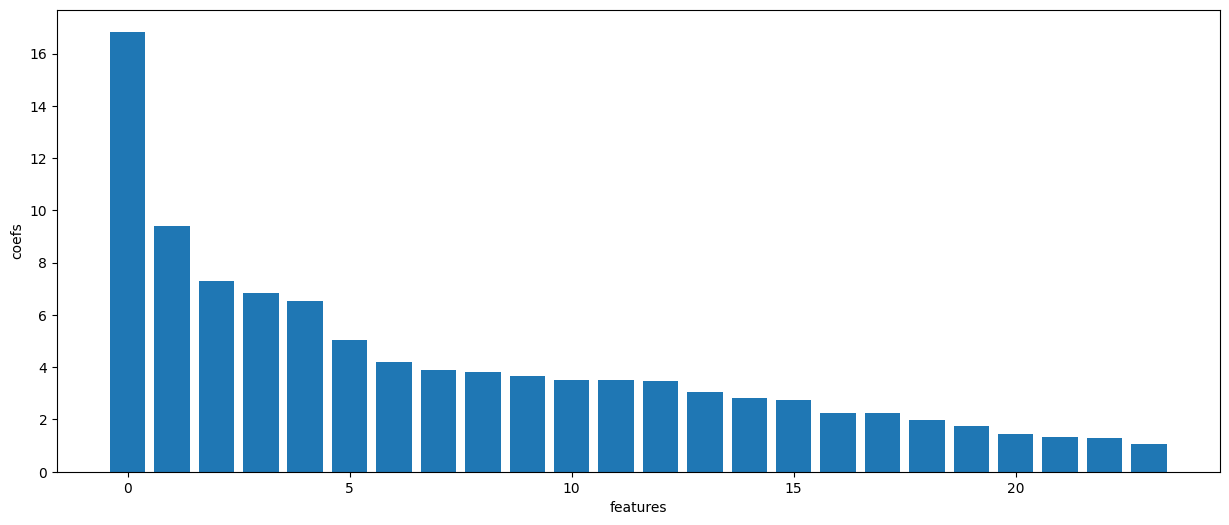

In [150]:
plt.figure(figsize=(15, 6))
plt.bar(np.arange(len(model_boost.feature_importances_)), sorted(model_boost.feature_importances_, reverse=True))
plt.xlabel('features')
plt.ylabel('coefs');

С помощью функции SelectFromModel из библиотеки sklearn отсею признаки со значимостью менее 2% и посмотрю, как изменилась точность модели.

In [151]:
selector = SelectFromModel(CatBoostClassifier(cat_features=categorical, random_seed=1, verbose=False), prefit=False, threshold=2)
X_tr = selector.fit_transform(X_train_boost, y_train_boost)
X_t = selector.transform(X_test_boost)

In [152]:
X_tr = pd.DataFrame(data=X_tr, columns = selector.get_feature_names_out())
X_t = pd.DataFrame(data=X_t, columns = selector.get_feature_names_out())

In [153]:
X_tr.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 113754 entries, 0 to 113753
Data columns (total 16 columns):
 #   Column         Non-Null Count   Dtype 
---  ------         --------------   ----- 
 0   Location       113754 non-null  object
 1   MinTemp        113229 non-null  object
 2   MaxTemp        113486 non-null  object
 3   Rainfall       112572 non-null  object
 4   Sunshine       59409 non-null   object
 5   WindGustDir    113754 non-null  object
 6   WindGustSpeed  106348 non-null  object
 7   WindDir3pm     113754 non-null  object
 8   Humidity9am    112334 non-null  object
 9   Humidity3pm    110841 non-null  object
 10  Pressure9am    102497 non-null  object
 11  Pressure3pm    102529 non-null  object
 12  Cloud3pm       67987 non-null   object
 13  Temp9am        113018 non-null  object
 14  Temp3pm        111548 non-null  object
 15  Month          113754 non-null  object
dtypes: object(16)
memory usage: 13.9+ MB


In [154]:
model_selector = CatBoostClassifier(cat_features=['Location', 'WindDir3pm', 'WindGustDir'], verbose=False)
model_selector.fit(X_tr, y_train_boost, eval_set=(X_t, y_test_boost), plot=True)
prediction_selector = model_selector.predict(X_t)
accuracy_score(y_test_boost, prediction_selector)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0.8658532297197511

In [171]:
print(f'В результате отсеивания наименее значимых параметров точность модели уменьшилась на {(accuracy_score(y_test_boost, prediction_selector) - accuracy_score(y_test_boost, prediction_boost))*100:.3}%')

В результате отсеивания наименее значимых параметров точность модели уменьшилась на -0.207%


Было отсяно 8 признаков из 24, при этом качество модели ухудшилось на 0.207%. В случае с большими моделями это может быть целесообразно, так как в дальнейшем это позволит выиграть много времени.

## 4.3 Кросс-валидация и подбор гиперпараметров модели

С помощью функции grid_search библиотеки catboost проведу кросс-валидацию и подбор гиперпараметров модели, затем обучу модель с выбранными параметрами и сравню точность с предыдущей моделью.

In [155]:
grid_params = {'learning_rate': [0.05, 0.1, 0.5],
               'iterations': [400, 600, 800],
					'depth': [6, 8, 10]}

In [156]:
X_grid = pd.concat([X_tr, X_t])
X_grid.info()

<class 'pandas.core.frame.DataFrame'>
Index: 142193 entries, 0 to 28438
Data columns (total 16 columns):
 #   Column         Non-Null Count   Dtype 
---  ------         --------------   ----- 
 0   Location       142193 non-null  object
 1   MinTemp        141556 non-null  object
 2   MaxTemp        141871 non-null  object
 3   Rainfall       140787 non-null  object
 4   Sunshine       74377 non-null   object
 5   WindGustDir    142193 non-null  object
 6   WindGustSpeed  132923 non-null  object
 7   WindDir3pm     142193 non-null  object
 8   Humidity9am    140419 non-null  object
 9   Humidity3pm    138583 non-null  object
 10  Pressure9am    128179 non-null  object
 11  Pressure3pm    128212 non-null  object
 12  Cloud3pm       85099 non-null   object
 13  Temp9am        141289 non-null  object
 14  Temp3pm        139467 non-null  object
 15  Month          142193 non-null  object
dtypes: object(16)
memory usage: 18.4+ MB


In [157]:
y_grid = pd.concat([y_train_boost, y_test_boost])

In [158]:
catboost_grid = CatBoostClassifier(verbose=False, cat_features=['Location', 'WindDir3pm', 'WindGustDir'], early_stopping_rounds=50)

In [159]:
grid_result = catboost_grid.grid_search(grid_params, X_grid, y_grid, verbose=False, plot=True)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))


bestTest = 0.3217054179
bestIteration = 399


bestTest = 0.314235319
bestIteration = 398

Stopped by overfitting detector  (50 iterations wait)

bestTest = 0.3217421001
bestIteration = 190


bestTest = 0.3167407233
bestIteration = 599


bestTest = 0.3112742761
bestIteration = 595

Stopped by overfitting detector  (50 iterations wait)

bestTest = 0.3217421001
bestIteration = 190


bestTest = 0.3143206791
bestIteration = 799


bestTest = 0.3097065696
bestIteration = 799

Stopped by overfitting detector  (50 iterations wait)

bestTest = 0.3217421001
bestIteration = 190


bestTest = 0.3163854609
bestIteration = 399


bestTest = 0.3117542731
bestIteration = 399

Stopped by overfitting detector  (50 iterations wait)

bestTest = 0.3255328335
bestIteration = 55


bestTest = 0.3125130492
bestIteration = 598


bestTest = 0.3101177398
bestIteration = 599

Stopped by overfitting detector  (50 iterations wait)

bestTest = 0.3255328335
bestIteration = 55


bestTest = 0.3106411533
bestIteration = 79

Посмотрим на лучшую комбинацию заданных гиперпараметров.

In [160]:
grid_result['params']

{'depth': 8, 'iterations': 800, 'learning_rate': 0.1}

In [161]:
model_tuned = CatBoostClassifier(depth = 8, iterations = 800, learning_rate = 0.1, verbose=False, cat_features=['Location', 'WindDir3pm', 'WindGustDir'])
model_tuned.fit(X_tr, y_train_boost, eval_set=(X_t, y_test_boost), plot=True)


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

In [162]:
prediction_grid = model_tuned.predict(X_t)
accuracy_score(y_test_boost, prediction_grid)

0.8639544287773832

In [163]:
print(f'В результате тюнинга гиперпараметров точность модели увеличилась на {(accuracy_score(y_test_boost, prediction_grid) - accuracy_score(y_test_boost, prediction_selector))*100:.3}%')

В результате тюнинга гиперпараметров точность модели увеличилась на -0.19%


Тюнинг гиперпараметров в данном случае оказал негативное воздействие на качество модели. Очевидно, параметры, которые были подобраны автоматически, оказались лучше, так что остановимся на предыдущем варианте модели.

## 4.4 Балансировка классов

Если мы хотим более точно предсказывать дни, когда будет идти дождь, в ущерб точности предсказаний дней без дождя, можно сбалансировать классы.

Для балансировки классов указываем в параметрах модели auto_class_weights=True.

In [164]:
model_balanced = CatBoostClassifier(cat_features=['Location', 'WindDir3pm', 'WindGustDir'], auto_class_weights='Balanced', verbose=False)
model_balanced.fit(X_tr, y_train_boost, eval_set=(X_t, y_test_boost), plot=True)
prediction_balanced = model_balanced.predict(X_t)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

In [165]:
confusion_matrix(y_test_boost, prediction_balanced)

array([[18402,  3696],
       [ 1291,  5050]], dtype=int64)

In [166]:
confusion_matrix(y_test_boost, prediction_selector)

array([[20945,  1153],
       [ 2662,  3679]], dtype=int64)

Количество правильных предсказаний дождливых дней стало больше в ущерб количеству правильных предсказаний дней без дождя.

In [167]:
print(f'Точность модели без балансировки классов: {accuracy_score(y_test_boost, prediction_selector)}')

Точность модели без балансировки классов: 0.8658532297197511


In [168]:
print(f'Точность модели с балансировкой классов: {accuracy_score(y_test_boost, prediction_balanced)}')

Точность модели с балансировкой классов: 0.8246422166742853


Ожидаемо, точность предсказаня модели снизилась. Таким образом, целесообразность балансировки классов следует обсуждать с заказчиком, обычно это актуально, например, в случае распознавания мошеннических банковских транзакций, где действительно важно распознавать больше мошеннических транзакций даже при увеличении ложных определений нормальных транзакций как мошеннических. В качестве аналогичного примера можно так же привести случай с обнаружением спам-писем.